It seems like morphing spectra the same way Paul is is going to help a lot.  See if I can get that to work.

In [1]:
from tensorflow import keras
#import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/"

In [6]:
!ls /Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/

10c_flux_weight_data                   LOFAR_from8403colorselected_all388.csv
DR14_zmin039_zmax068.csv               LOFAR_spectra
DR14_zmin2085_zmax4227.csv             RebinnedHSTData
DR14_zmin209_zmax228.csv               VLAspectra_all8403
HST_Chandra_Redshifts.csv              grdr7.8403col.radec.platemjdfiber.csv
HST_Reconstructions                    s7_flux_weight_data
HST_Reconstructions_sudo               speclist_8403_VLA_colselected.txt
HST_Reconstructions_sudo2              speclist_LOFAR.txt
HST_SDSS_Data                          total_flux_weight_data
HST_train


In [7]:
#Load the metadata of all 8403 objects
dat = pd.read_csv(path+"grdr7.8403col.radec.platemjdfiber.csv")
dat.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET      MI_Z2    LOGLBOL  ...  LOGL_MGII    EW_MGII  \
0  51608               0 -27.635967  47.094489  ...  44.376721  26.967853   
1  51633               0 -26.986037  46.849020  ...  44.163982  28.819893   
2  51909               0 -27.539811  47.031922  ...  44.413369  34.569696   
3  51909               0 -26.907112  46.713170  ...  43.993350  26.541603   
4  51883               0 -27.177639  46.782514  ...  44.111600  29.946692   

   LOGL_BROAD_MGII  EW_BROAD_MGII   LOGL_CIV     EW_CIV  VOFF_CIV_PEAK  \
0        44.366029      26.312016  44.901087  36.111955     712.104035   
1        44.132085      26.779087  44.658484  32.642452     305.754876   
2        44.408935      34.218546  44.929561  56.727337     -26.149363   
3        43.989344      26.297896  44.421090  25.101699    1000.490718   
4        44.104876      29.486556  44.499160  28.892388     530.384452   

   LOGEDD_RATIO      Z_HW      E_BV  
0     -0.494012  1.779394  0.069739  
1     -0.837157  1.882529  0.035407  
2     -0.780922  1.668503  0.044319  
3     -0.337591  1.750491  0.031931  
4     -0.564674  1.823599  0.048818  

[5 rows x 25 columns]

In [9]:
sdss_names = dat[["name"]].values.flatten()
z     = dat[["REDSHIFT_1"]].values.flatten()
plate = dat[["PLATE_1"]].values.flatten()
mjd   = dat[["MJD_1"]].values.flatten()
fiber = dat[["FIBER_1"]].values.flatten()
BAL   = dat[["BAL_FLAG"]].values.flatten()!=0

This cell can take a while.

In [10]:
min(z), max(z)

(1.6261999607086182, 2.0887000560760502)

In [11]:
N=0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open(path+"VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print(path+"VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    print(min(sdss_wave[wavemask]), max(sdss_wave[wavemask]), len(sdss_wave[wavemask]))
    N+=1
    if N>10: break

1443.2551 2960.3506 3121
1443.1803 2960.878 3122
1443.0975 2960.708 3122
1443.0214 2960.552 3122
1443.2087 2960.936 3122
1443.0784 2960.6692 3122
1443.316 2960.4756 3121
1443.0242 2960.5576 3122
1443.213 2960.9468 3122
1443.0815 2960.677 3122
1443.0665 2960.645 3122


In [12]:
3790 / (1+1.625), 3790 / (1+2.1), 9150 / (1+1.65), 9150 / (1+2.09)

(1443.8095238095239,
 1222.5806451612902,
 3452.8301886792456,
 2961.1650485436894)

In [12]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
BAL_list= []
N = 0

for sdss_name, red, pl, mj, fib, bal in zip(sdss_names, z, plate, mjd, fiber, BAL):
    try:
        hdul_spec = fits.open(path+"VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print(path+"VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 3121:
        names.append(sdss_name)
        spectra.append(sdss_flux[:3121])
        wave.append(sdss_wave[:3121])
        ivar.append(sdss_ivar[:3121])
        found.append(N)
        if bal: BAL_list.append(bal)

    N+=1
    if N%1000==0: print(N)  
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found = np.array(found)

1000
2000
3000
4000
5000
6000
/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/VLAspectra_all8403/lite/2516/spec-2516-54240-0119.fits NOT FOUND
/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/VLAspectra_all8403/lite/2516/spec-2516-54240-0125.fits NOT FOUND
7000
8000
/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/VLAspectra_all8403/lite/2256/spec-2256-53859-0031.fits NOT FOUND


----

Now build the autoencoder.  See Chapter 17 of Geron, Hands-on Machine Learning...

In [13]:
spectra.shape

(8368, 3121)

In [16]:
spec_mean = spectra.mean(axis=0)

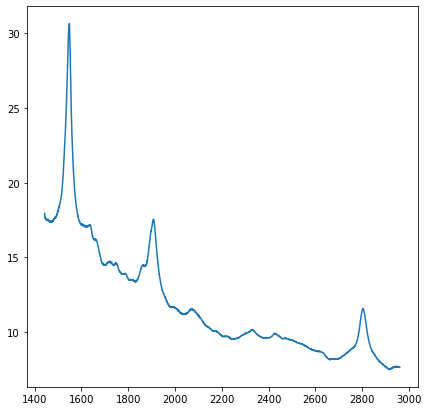

In [17]:
fig = plt.figure(figsize=(7,7))
plt.plot(wave[0], spec_mean)
plt.show()

In [15]:
import tensorflow.keras.backend as K

In [16]:
wave[0]

array([1443.2551, 1443.5872, 1443.9202, ..., 2958.9875, 2959.668 ,
       2960.3506], dtype=float32)

In [335]:
#Mask CIV absorption
n_latent = 6
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
MASK = K.variable(MASKK)

In [336]:
type(spectra[0].shape)

tuple

In [337]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=spectra[0].shape),
    keras.layers.Lambda(lambda x: x*MASK), #this layer is the mask - turn off corresponding neurons
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(n_latent, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[n_latent]),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(spectra[0].shape[0]) #no activation function since we want actual pixel values
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [373]:
stacked_ae.compile(loss="logcosh", optimizer=keras.optimizers.Nadam(lr=6e-6, beta_1=0.9, beta_2=0.999))

In [374]:
X_train = spectra[:5000]
X_valid = spectra[5000:7000]
X_test  = spectra[7000:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=15,
                         validation_data=(X_valid, X_valid))

Train on 5000 samples, validate on 2000 samples
Epoch 1/15
5000/5000 [==============================] - 6s 1ms/step - loss: 0.4661 - val_loss: 0.4450
Epoch 2/15
5000/5000 [==============================] - 3s 583us/step - loss: 0.4660 - val_loss: 0.4449
Epoch 3/15
5000/5000 [==============================] - 3s 587us/step - loss: 0.4660 - val_loss: 0.4448
Epoch 4/15
5000/5000 [==============================] - 3s 587us/step - loss: 0.4659 - val_loss: 0.4448
Epoch 5/15
5000/5000 [==============================] - 3s 584us/step - loss: 0.4659 - val_loss: 0.4447
Epoch 6/15
5000/5000 [==============================] - 3s 593us/step - loss: 0.4659 - val_loss: 0.4448
Epoch 7/15
5000/5000 [==============================] - 3s 585us/step - loss: 0.4658 - val_loss: 0.4447
Epoch 8/15
5000/5000 [==============================] - 3s 583us/step - loss: 0.4658 - val_loss: 0.4447
Epoch 9/15
5000/5000 [==============================] - 3s 581us/step - loss: 0.4658 - val_loss: 0.4447
Epoch 10/15
5000/5

In [369]:
X_train.shape

(5000, 3121)

Note: This wasn't the only round of training.  Want to start with higher learning rate then slowly decrease.

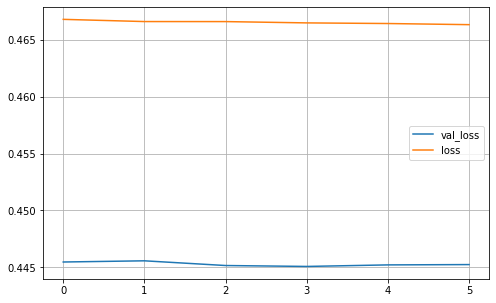

In [370]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [375]:
reconst = stacked_ae.predict(np.array([X_valid[0]]))

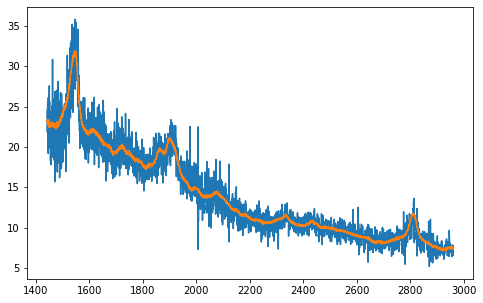

In [376]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[6000], X_valid[0])
plt.plot(wave[6000], reconst[0])
plt.show()

In [377]:
n_spectra = 100
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

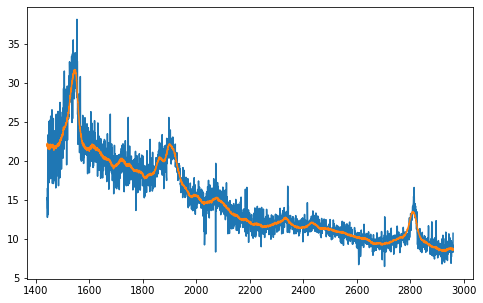

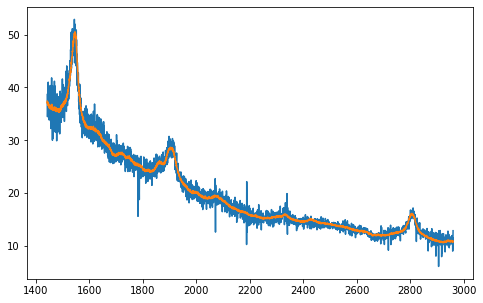

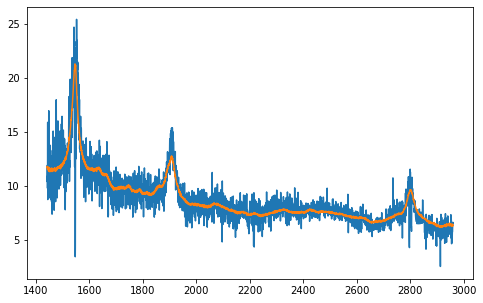

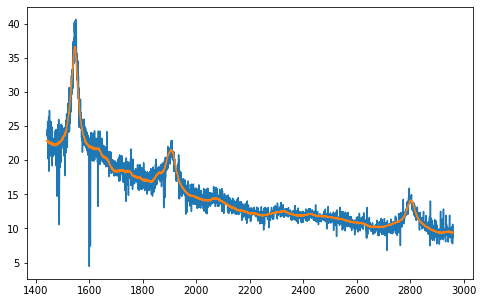

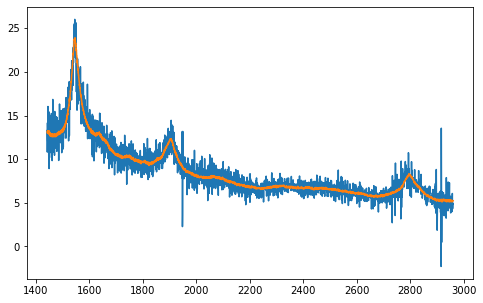

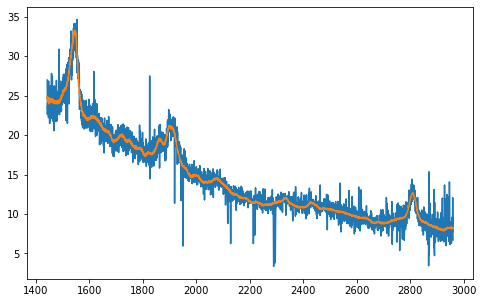

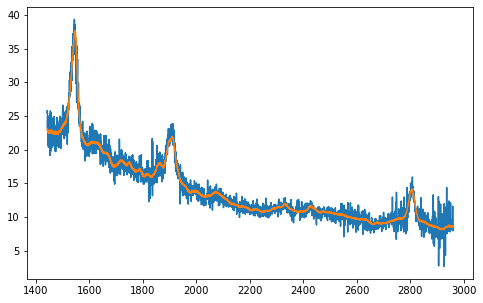

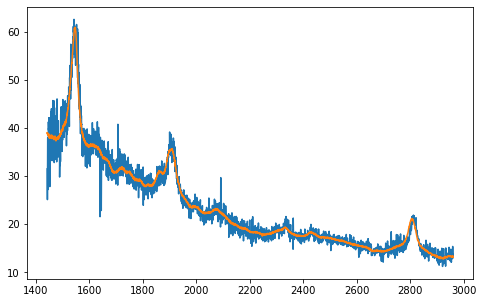

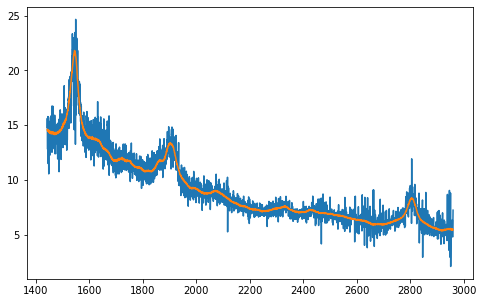

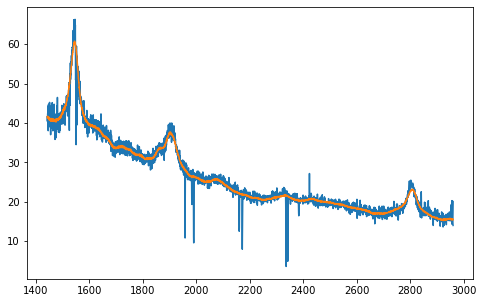

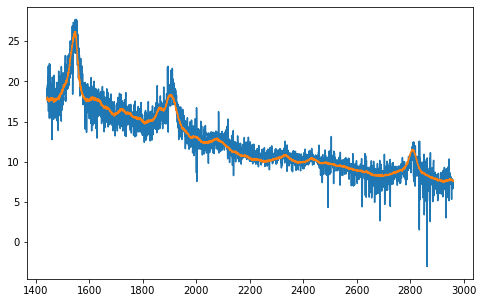

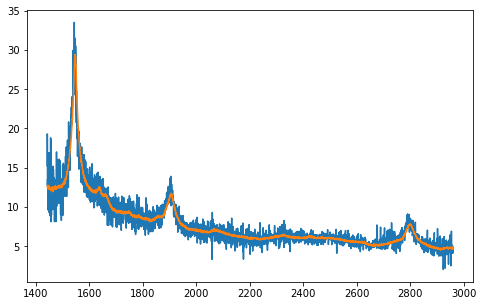

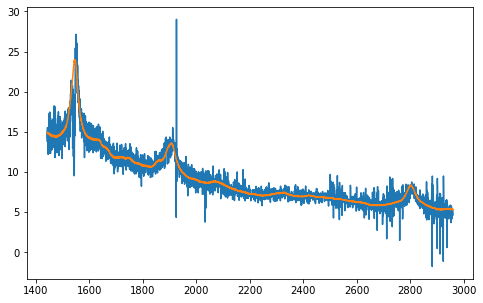

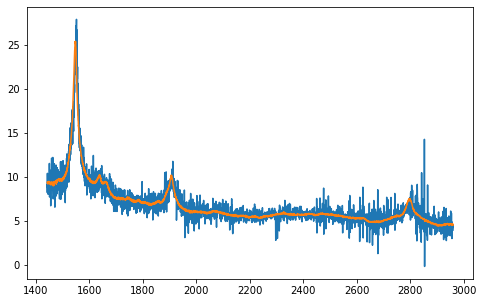

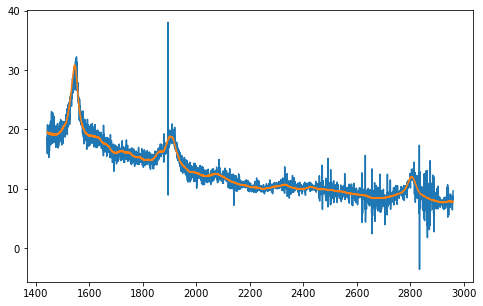

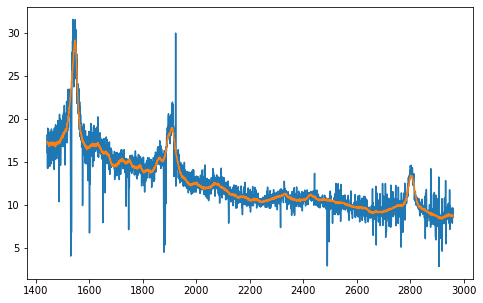

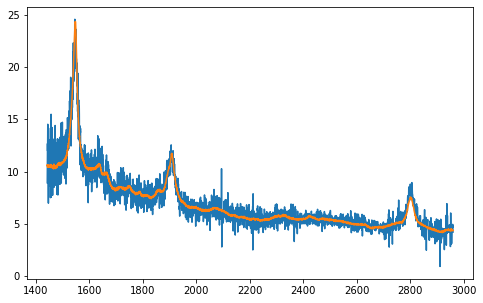

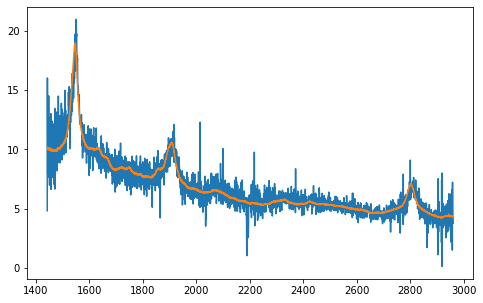

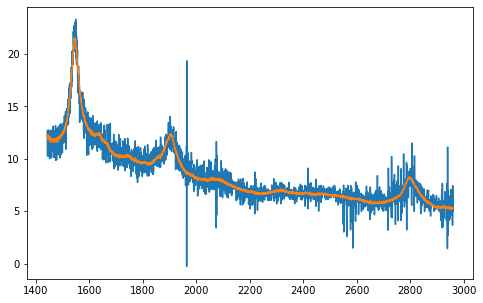

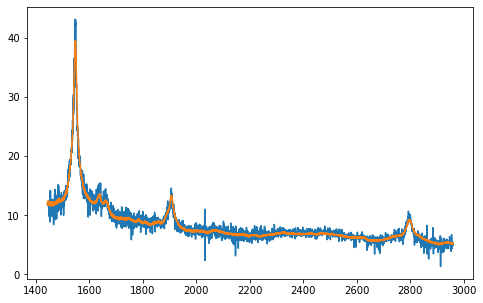

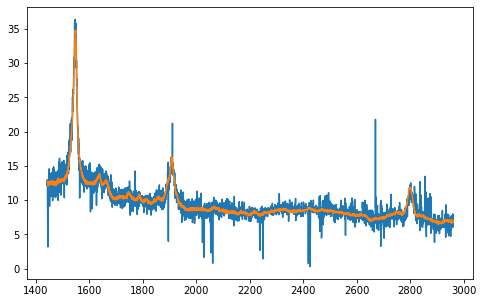

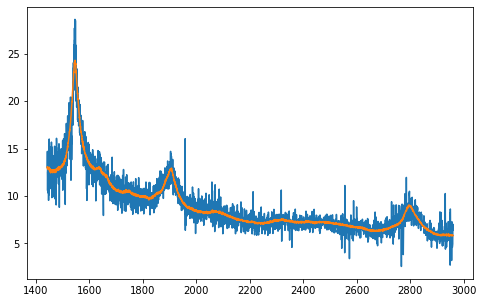

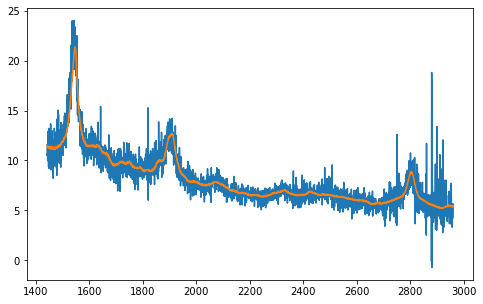

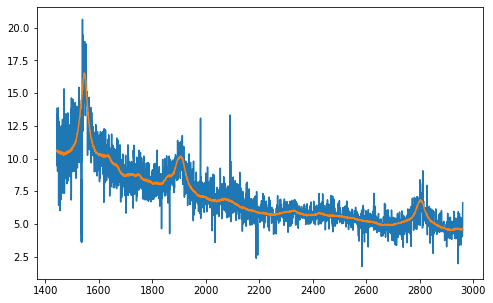

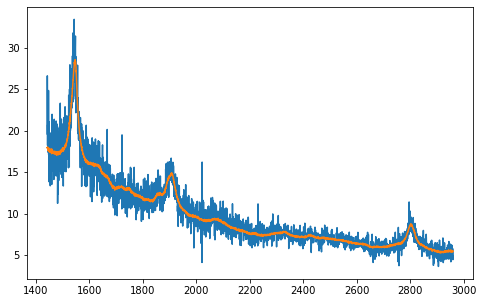

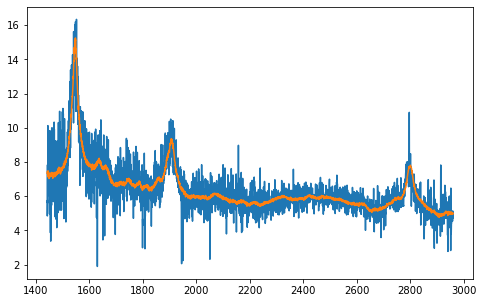

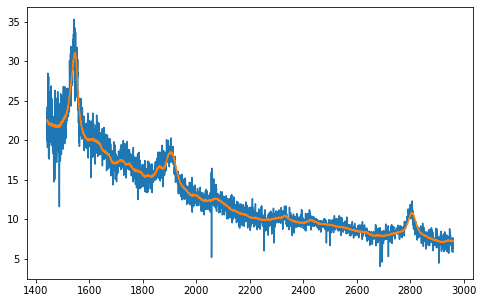

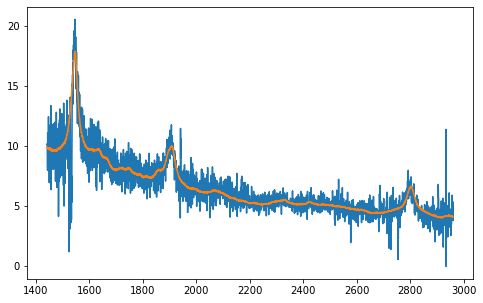

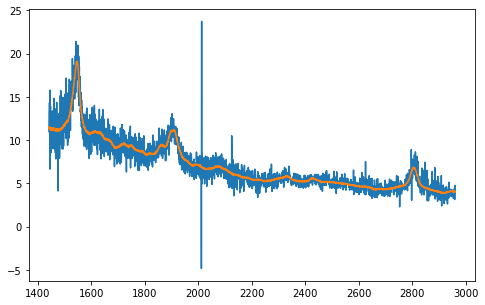

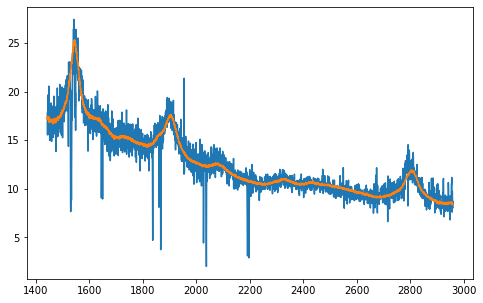

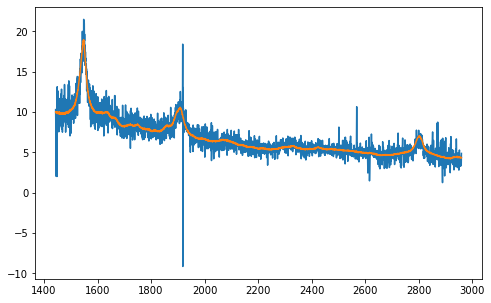

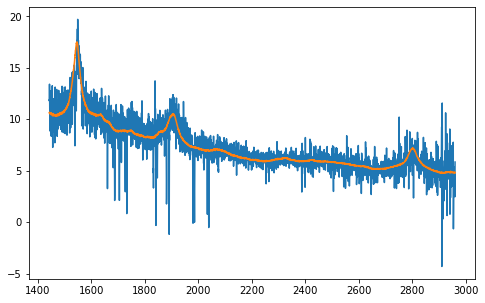

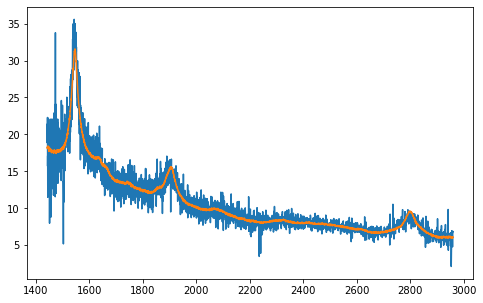

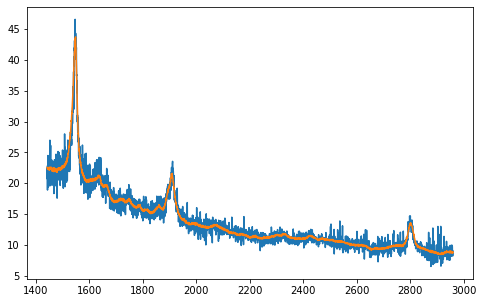

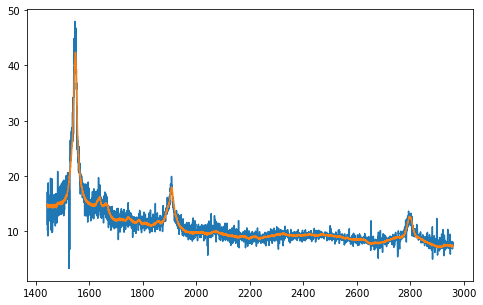

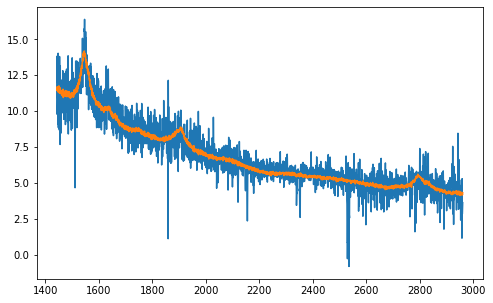

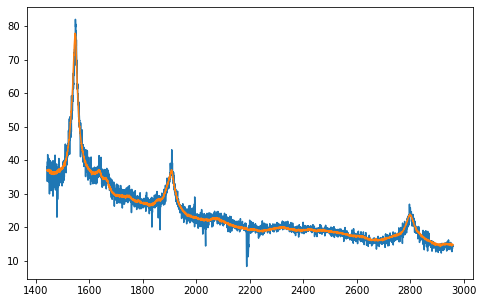

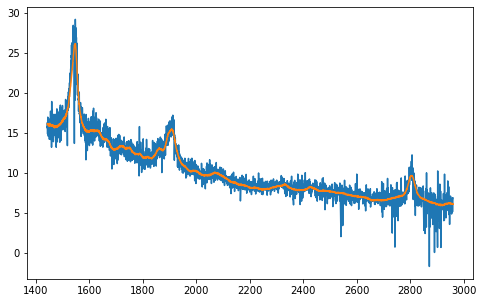

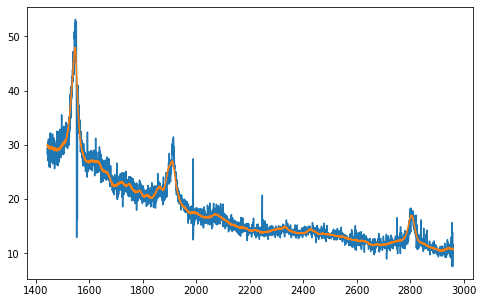

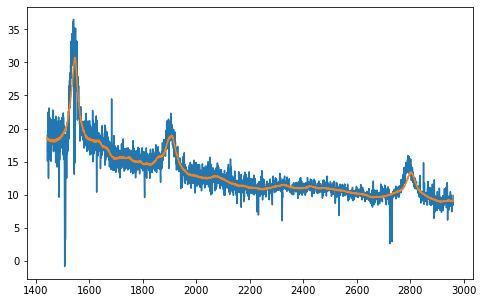

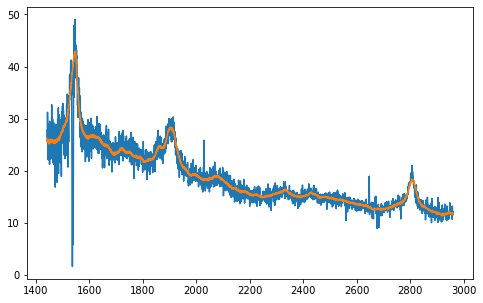

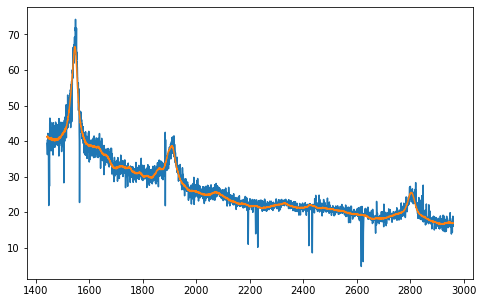

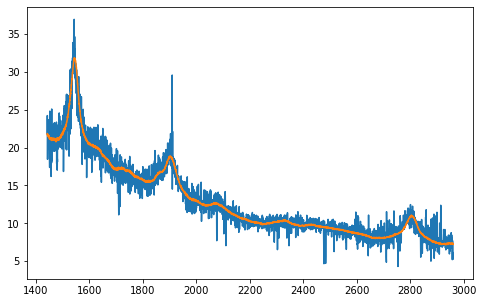

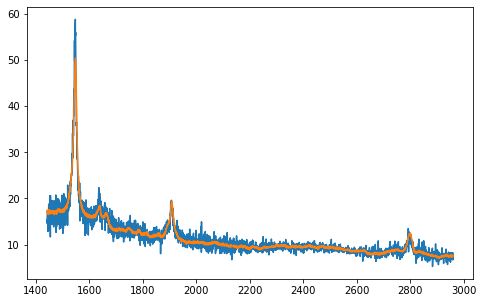

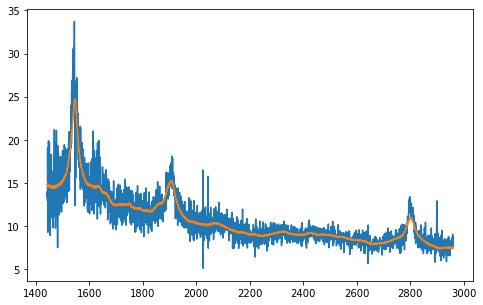

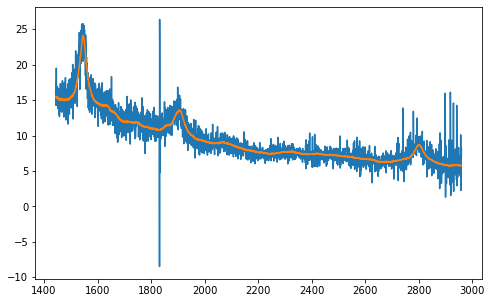

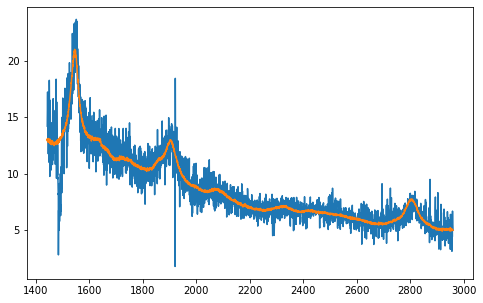

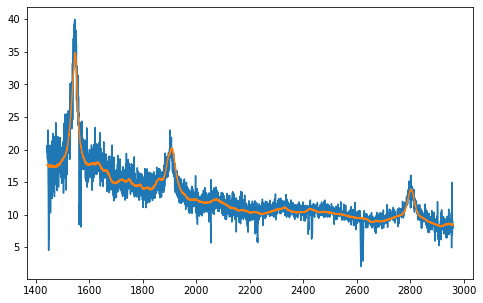

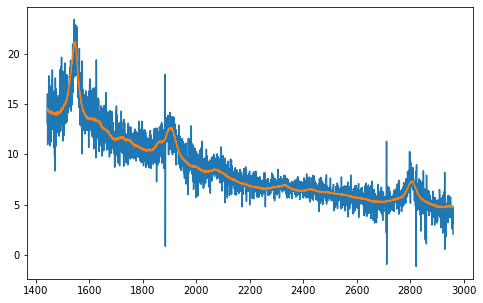

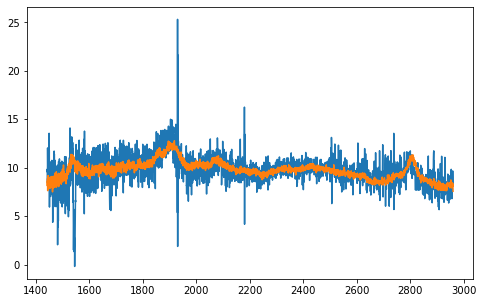

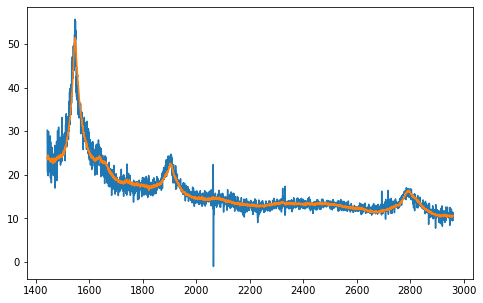

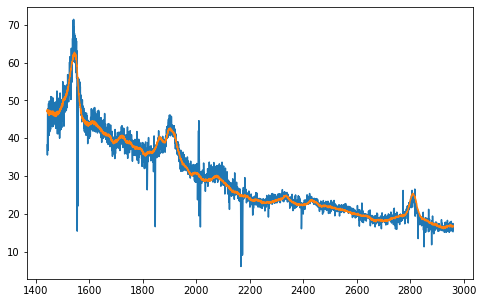

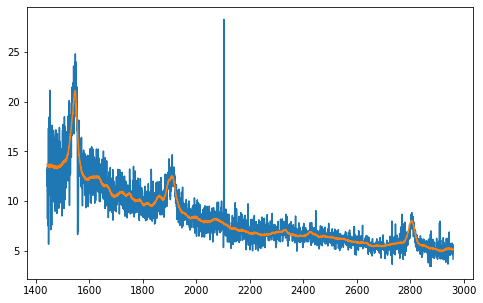

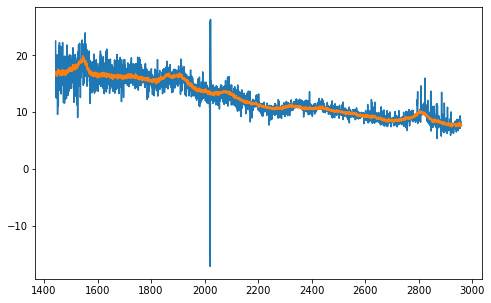

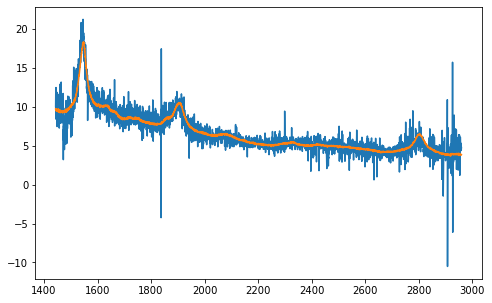

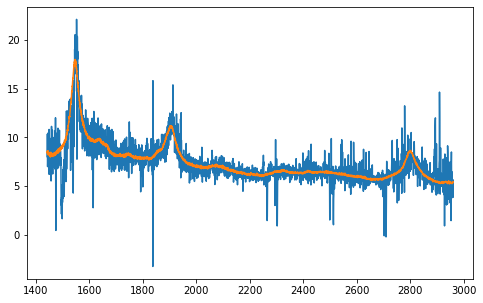

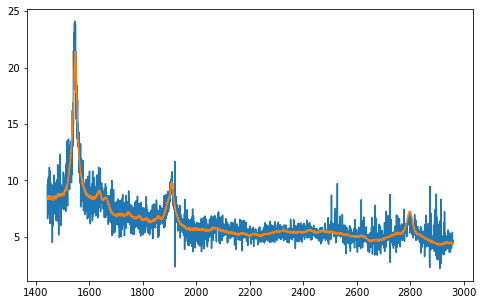

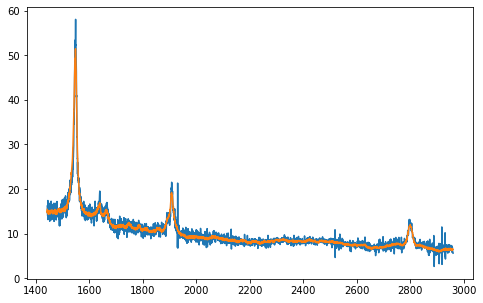

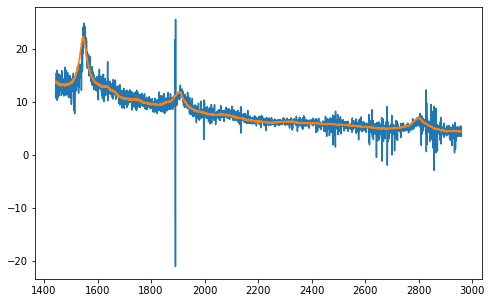

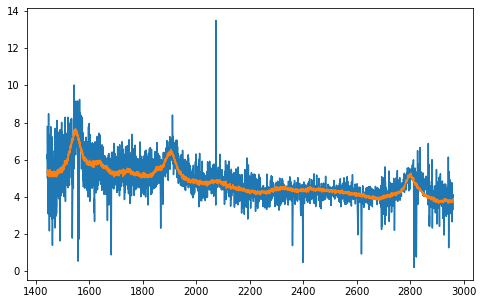

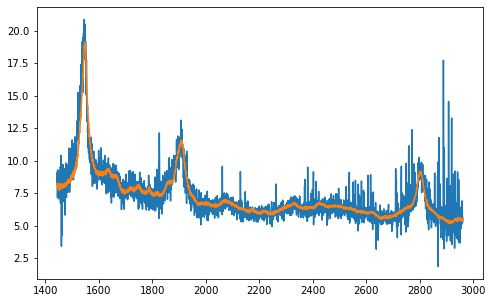

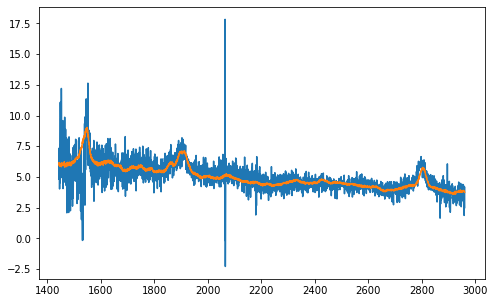

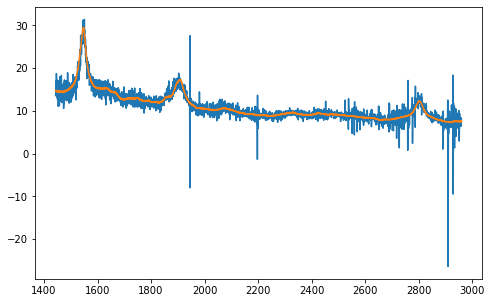

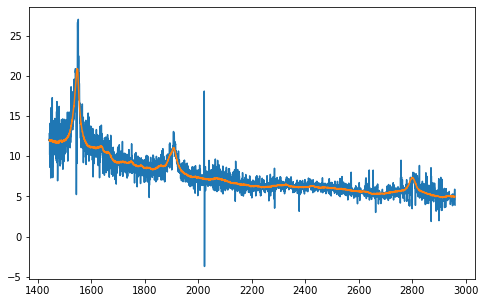

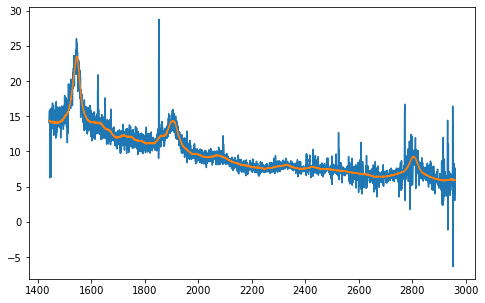

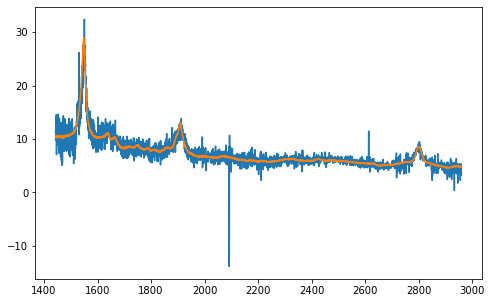

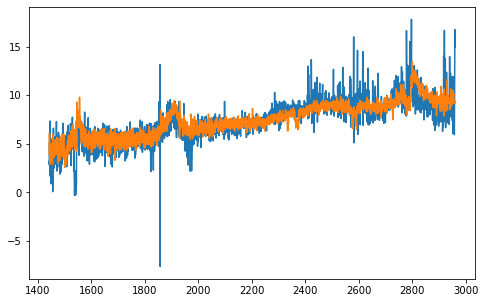

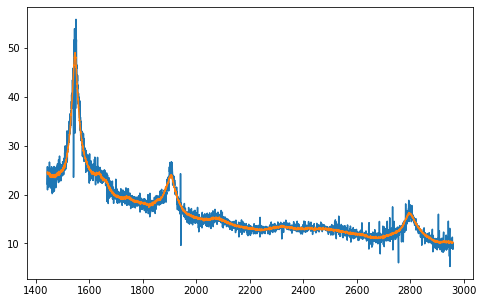

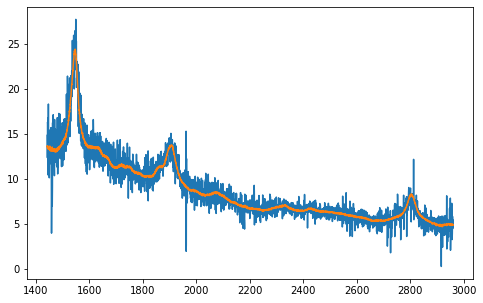

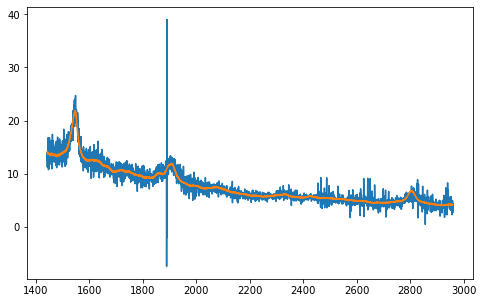

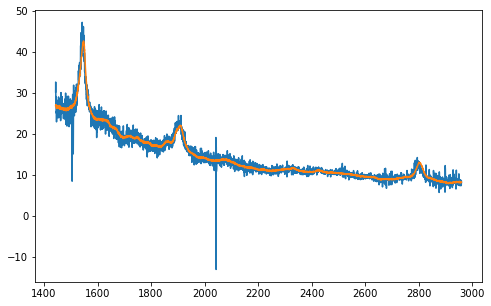

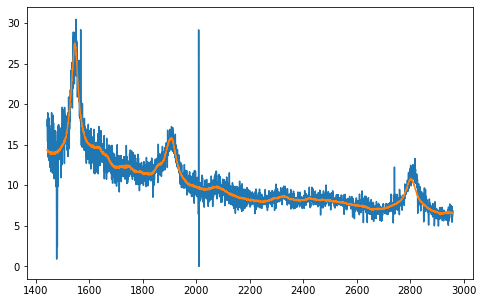

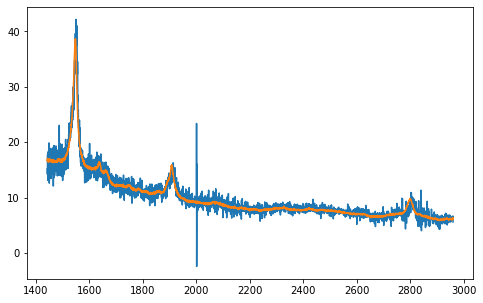

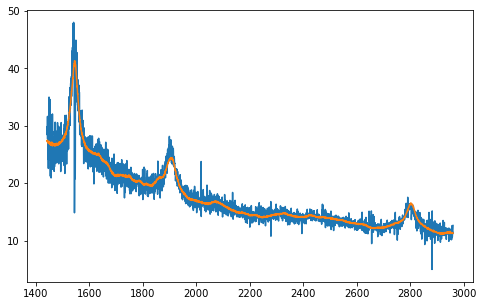

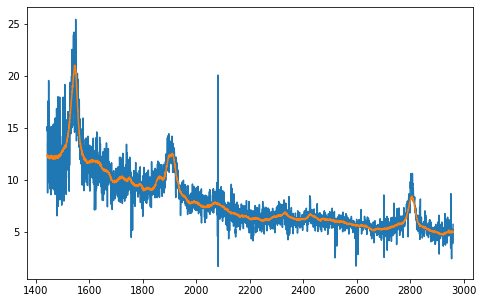

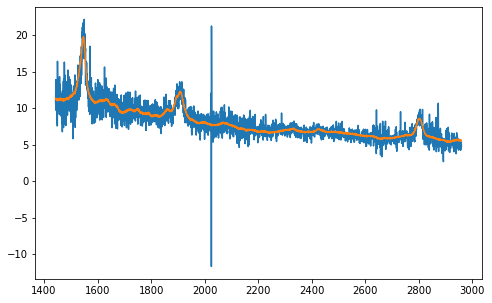

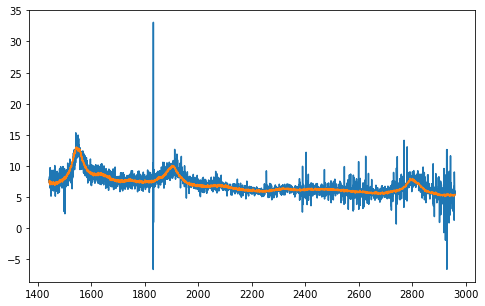

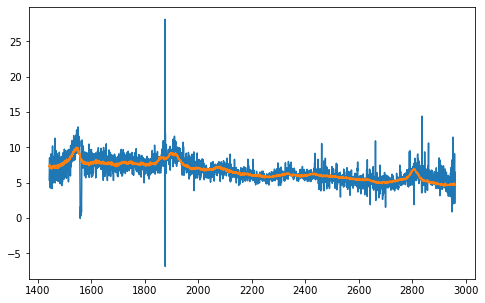

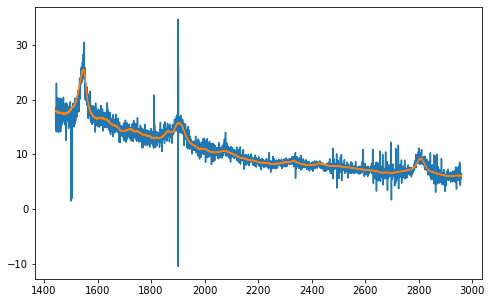

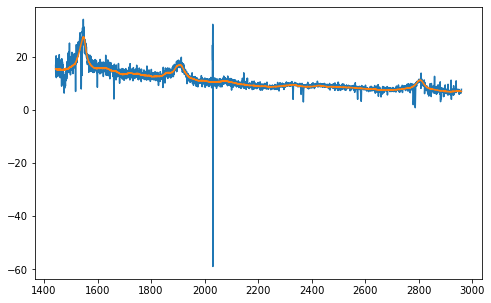

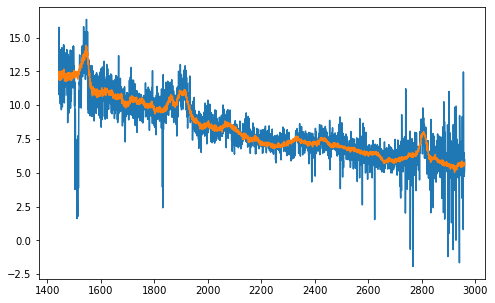

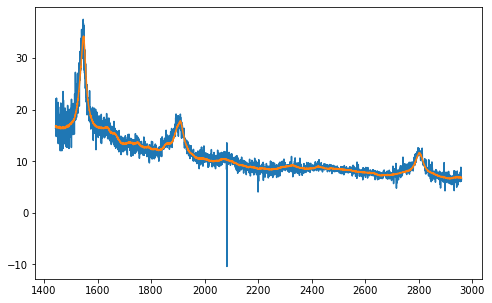

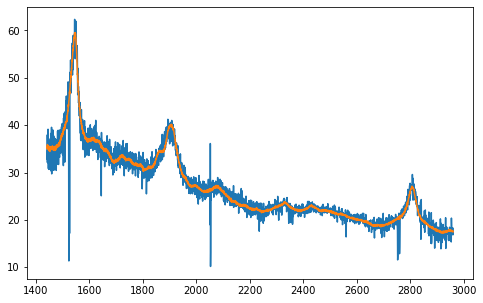

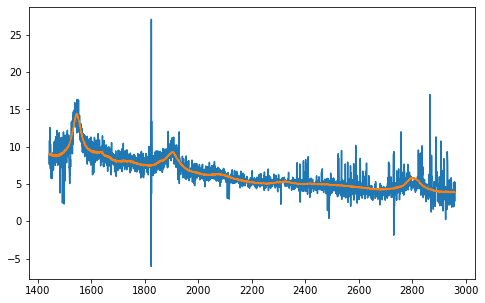

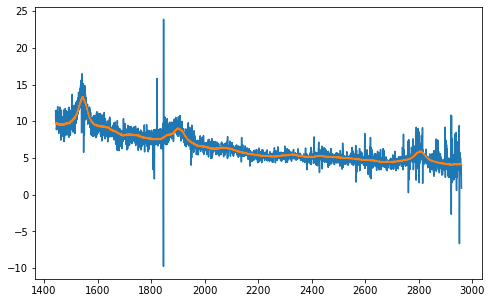

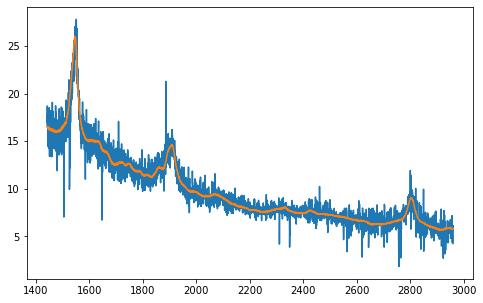

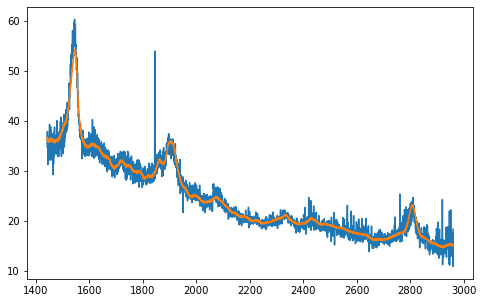

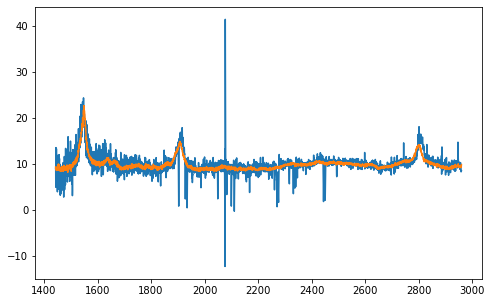

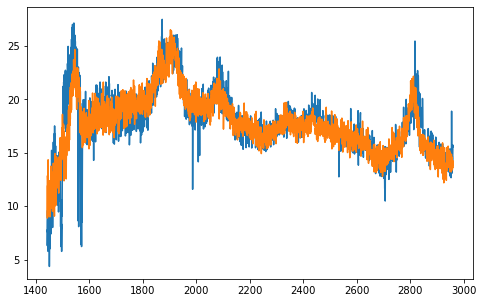

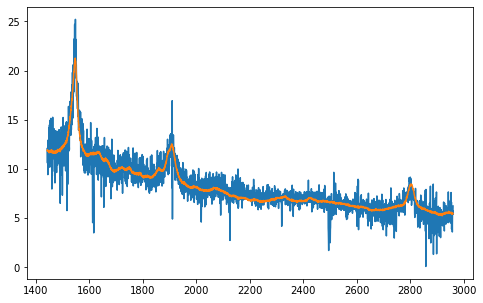

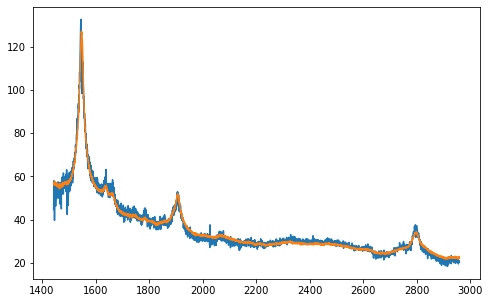

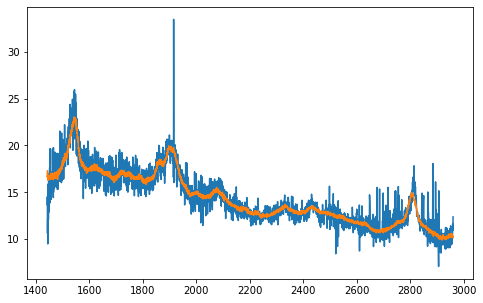

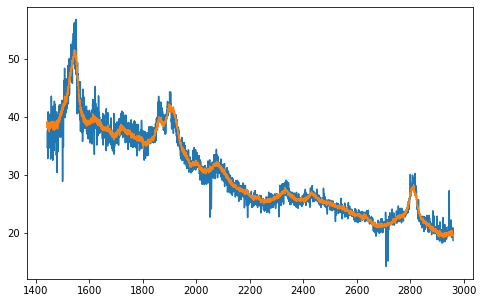

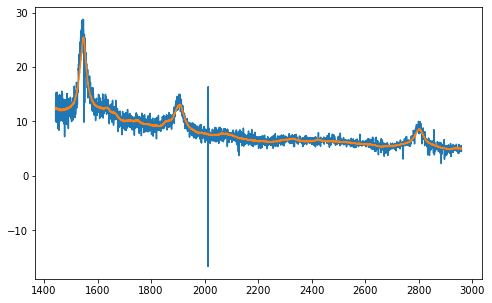

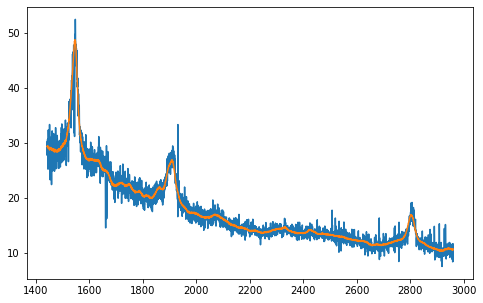

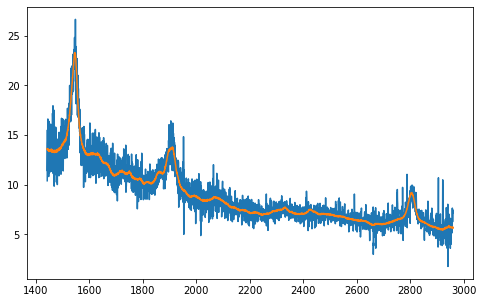

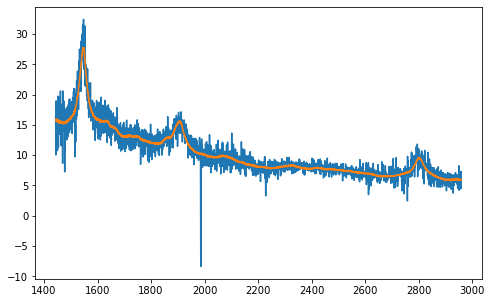

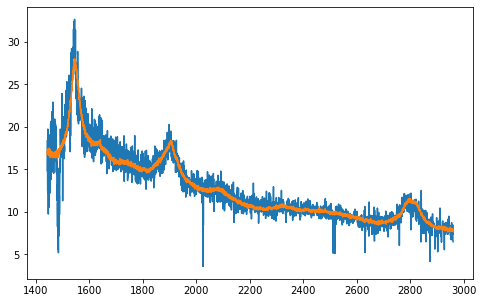

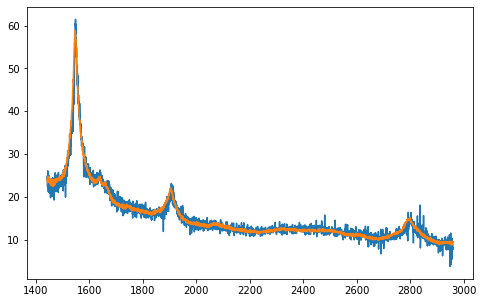

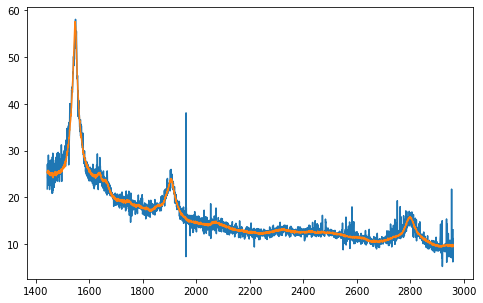

In [378]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[6000+i], X_test[i])
    plt.plot(wave[6000+i], reconst[i])
    plt.show()

Generally pretty good, but definitely weak in some areas.  Stronger emission lines (CIII] and MgII) it seems to struggle with; odd that it seems to sometimes get those spectra right though.  Maybe move to DR14 and get some more spectra now; hopefully more training data will help with some issues.

``Adam`` is definitely the optimizer to use.

In [379]:
X = np.vstack([X_train, X_valid, X_test])
X.shape

(8368, 3121)

In [380]:
#Compress the spectra down to 10 dimensions
X_compressed = stacked_encoder.predict(X)

In [381]:
X_compressed.shape

(8368, 6)

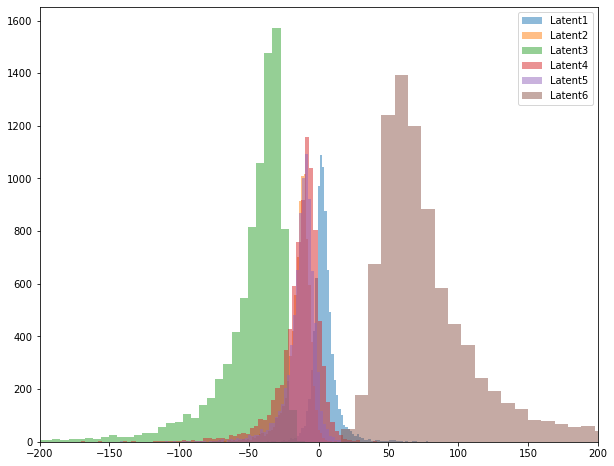

In [450]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.xlim(-200,200)
plt.legend(loc="best")
plt.show()

Note: The SeLU activation function leads to saturation at ~-1.75 for four of the latent parameters; use leaky ReLU to get nice distributions like above.

In [311]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=150)
projTSNE2 = tsne.fit_transform(X_compressed)

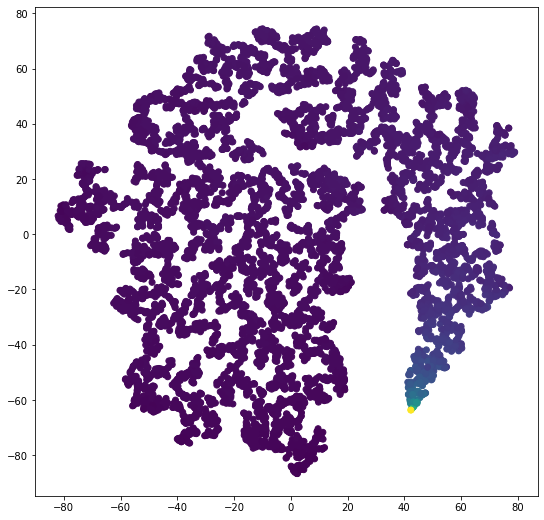

In [313]:
fig = plt.figure(figsize=(9,9))

plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,2])
plt.show()

Interesting... 

Now want to see what exactly each latent parameter represents.  Since we're dealing with 10 parameters, the space created by them is essentially a 10-dimensional hypersphere.  We can track the change caused by one parameter by holding the rest constant (at their median), and changing the value of the given latent parameter incrementally.  Then, after the increment, feed the latent parameters to the decoder and see what information it holds.

One strange (troublesome?) thing is that certain parameters change much more than others, but maybe I should just be running PCA to see which ones to throw out??  (That is, for visualization of just the parameters-- we still need them to reconstruct the spectrum because the decoder needs all)

In [241]:
X_compressed

array([[  47.630016,  197.03957 , -184.1207  ,  -89.2031  ],
       [  36.250057,  113.70633 , -103.53432 ,  -45.116665],
       [  14.480593,  204.19533 , -176.93404 ,  -88.13649 ],
       ...,
       [  22.919058,  101.55975 ,  -91.199196,  -47.13763 ],
       [  19.449799,   58.9966  ,  -61.070705,  -30.861652],
       [  12.37883 ,   56.4338  ,  -49.568985,  -23.72406 ]],
      dtype=float32)

In [242]:
np.median(X_compressed, axis=0)

array([ 22.850687,  94.23455 , -85.1508  , -42.130905], dtype=float32)

In [431]:
def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

CIV EW = 26.11 Å, CIV Blueshift = 581.67 km/s


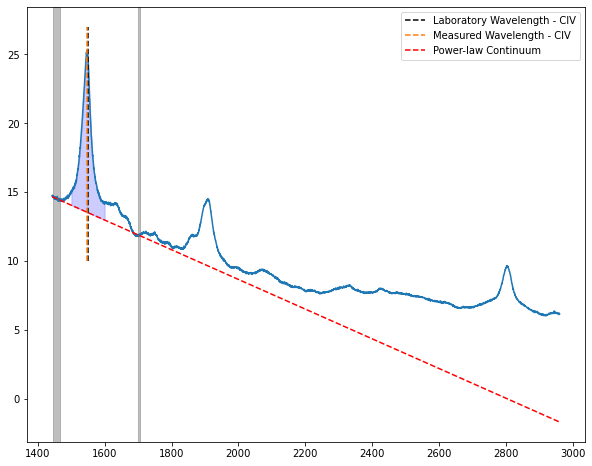

In [432]:
test = stacked_decoder.predict(np.array([np.median(X_compressed, axis=0)]))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(wave[0], test[0])
ax.plot([1549.48,1549.48], [10, 27], "--k", label="Laboratory Wavelength - CIV")
#plt.xscale("log")

#Find the blueshift
CIV = (wave[0]>1465)&(wave[0]<1650)
civ_peak = wave[0][CIV][test[0][CIV].argmax()]
ax.plot([civ_peak,civ_peak], [10, 27], "--", label="Measured Wavelength - CIV")
#print(((1549.48-civ_peak)/1549.48)*3e5, "km/s")


#Fit continuum
cont1 = ((wave[0]>=1445)&(wave[0]<=1465))
cont2 = ((wave[0]>=1700)&(wave[0]<=1705))
ax.axvspan(1445, 1465, alpha=0.5, color='grey')
ax.axvspan(1700, 1705, alpha=0.5, color='grey')


m,b = np.polyfit(np.concatenate((wave[0][cont1], wave[0][cont2])), np.concatenate((test[0][cont1], test[0][cont2])), 1)
continuum = wave[0]*m + b
plt.plot(wave[0], continuum, "--r", label="Power-law Continuum")\

#Plot EW to compute
EW = ((wave[0]>=1500)&(wave[0]<=1600))
ax.fill_between(wave[0][EW], 
                continuum[EW],
                test[0][EW], color="blue", alpha=0.2)

#And compute the EW
CIV_EW = 0
ew_list = [0.]
for i in range(len(wave[0][EW])):
    try:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i+1] - wave[0][EW][i] )
    except IndexError:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i] - wave[0][EW][i-1] )
        
    ew_list.append(CIV_EW)
        
        
ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()

print("CIV EW = %.2f Å, CIV Blueshift = %.2f km/s" % (CIV_EW, blueshift(wave[0][EW][ind_half_flux])))

plt.legend(loc="best")
plt.show()

In [433]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = np.min(X_comp[:,n]), min(np.max(X_comp[:,n]), 400)
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [434]:
get_latent(X_compressed, 0, n_diff).shape

(12, 3121)

In [435]:
n_diff = 12
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
predict4 = get_latent(X_compressed, 3, n_diff)
predict5 = get_latent(X_compressed, 4, n_diff)
predict6 = get_latent(X_compressed, 5, n_diff)
#predict7 = get_latent(X_compressed, 6, n_diff)
#predict8 = get_latent(X_compressed, 7, n_diff)
#predict9 = get_latent(X_compressed, 8, n_diff)
#predict10= get_latent(X_compressed, 9, n_diff)

In [436]:
predict1[0]

array([ 6.46762276, -2.50852895,  1.28291249, ..., 14.42936134,
        5.04951906,  1.96778786])

In [437]:
def plot_latent(prediction, omit=0, reverse=True):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    plt.legend(loc="best")
    plt.show()

#### Param1

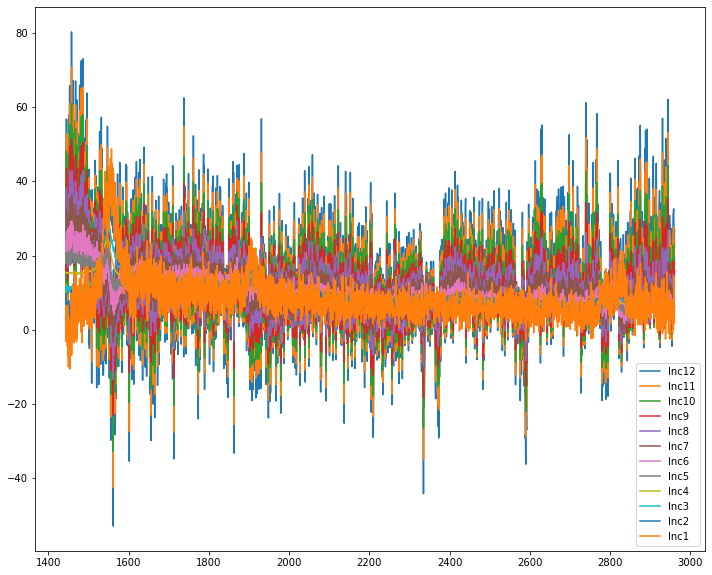

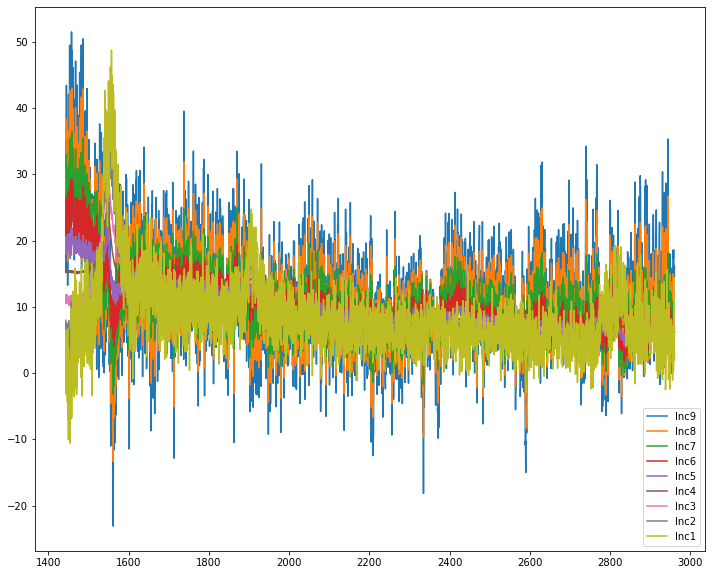

In [440]:
plot_latent(predict1, reverse=True)
plot_latent(predict1, omit=3,  reverse=True)

#### Param2

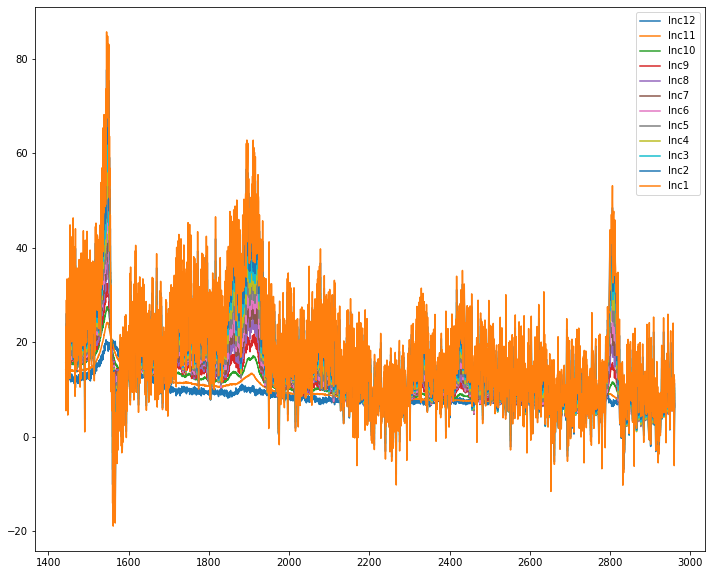

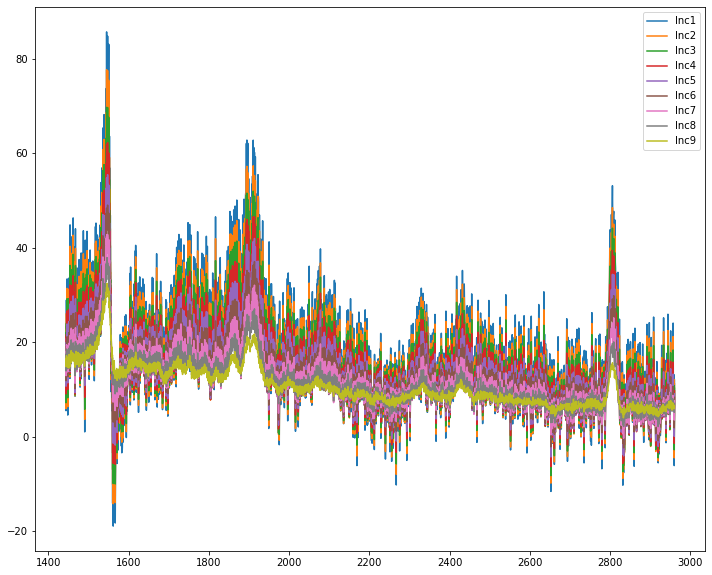

In [443]:
plot_latent(predict2)
plot_latent(predict2, omit=3, reverse=False)

#### Param3

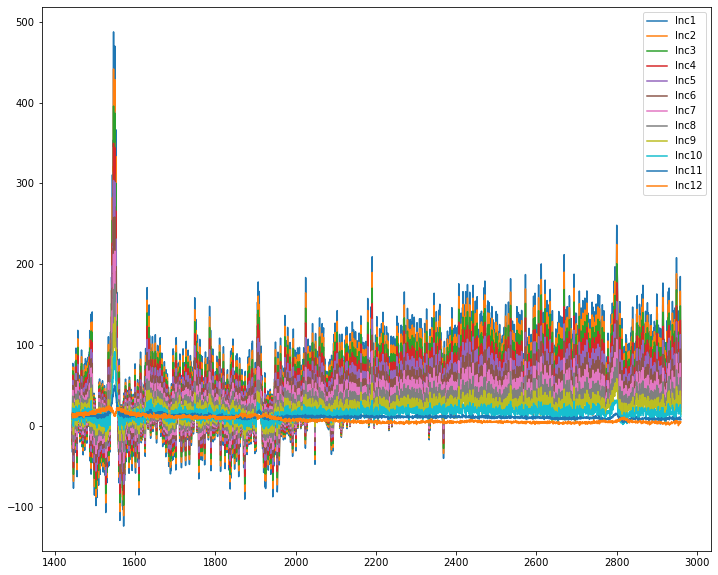

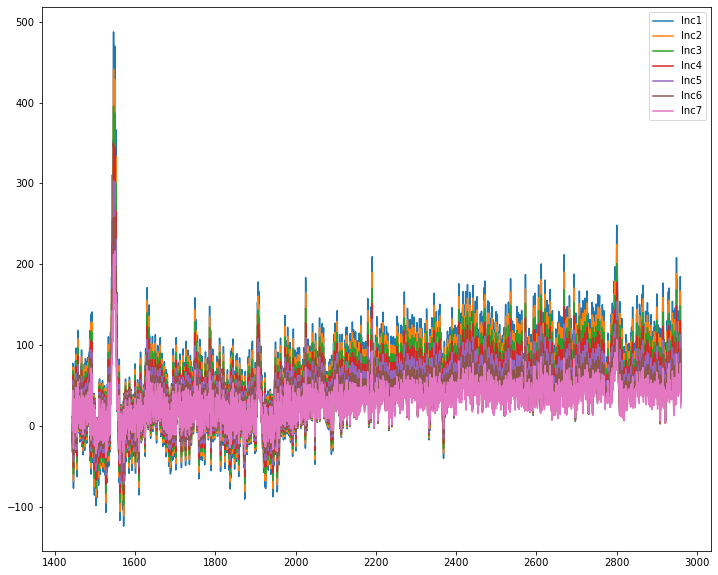

In [444]:
plot_latent(predict3, reverse=False)
plot_latent(predict3, omit=5, reverse=False)


#### Param4

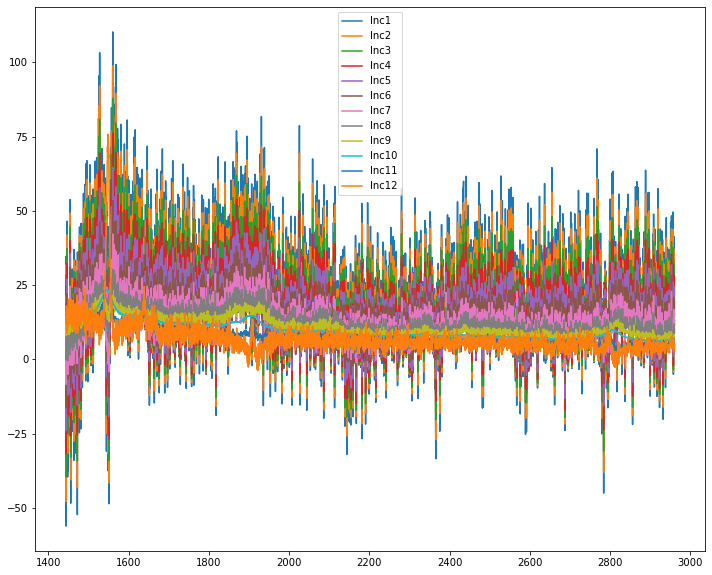

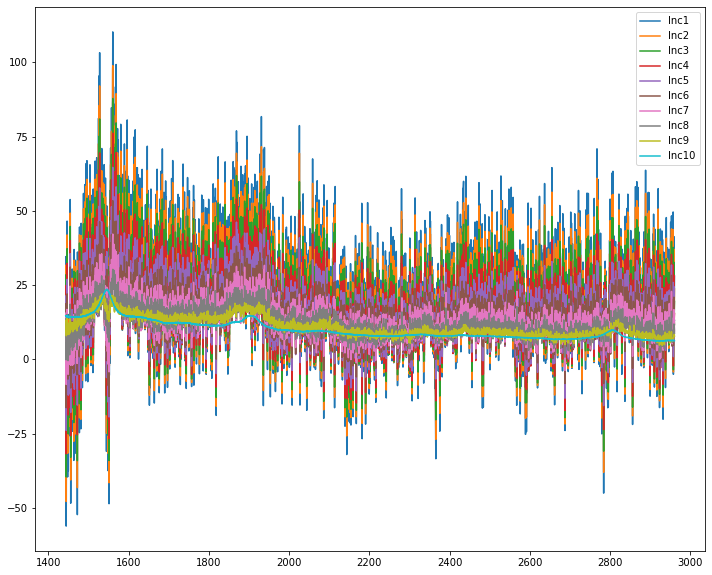

In [445]:
plot_latent(predict4, reverse=False)
plot_latent(predict4, omit=2, reverse=False)

Higher vals tend towards CIV BAL, noisier spectrum

#### Param5

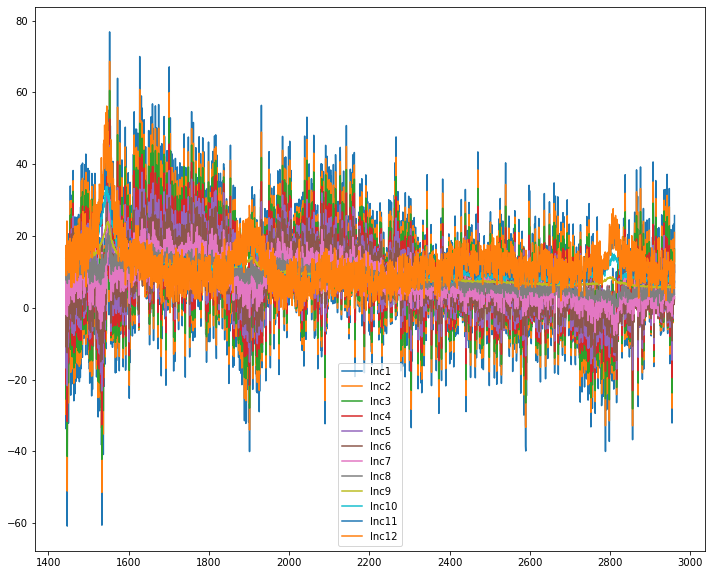

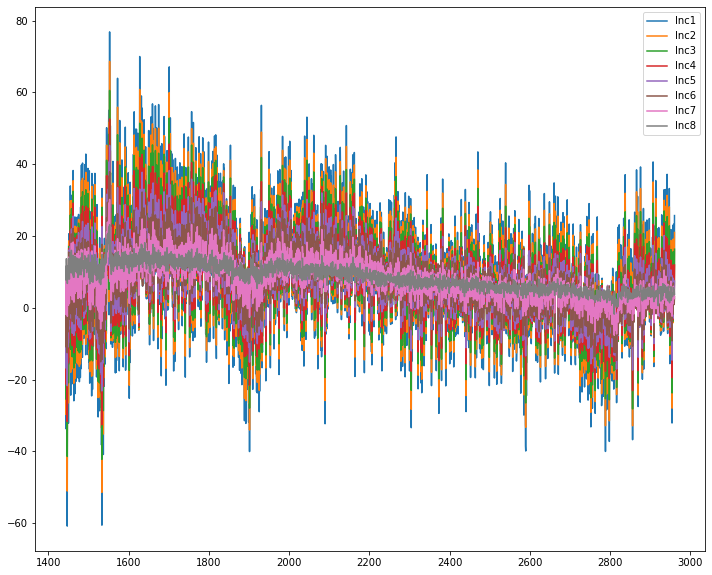

In [448]:
plot_latent(predict5, reverse=False)
plot_latent(predict5, omit=4, reverse=False)

#### Param6

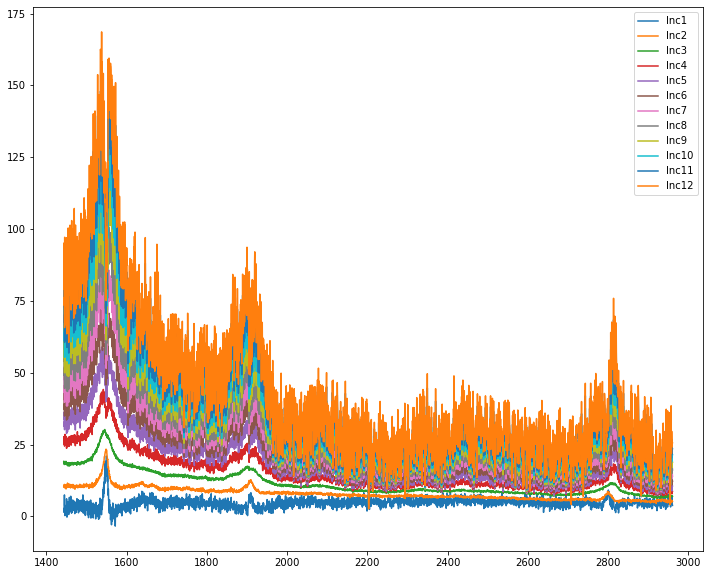

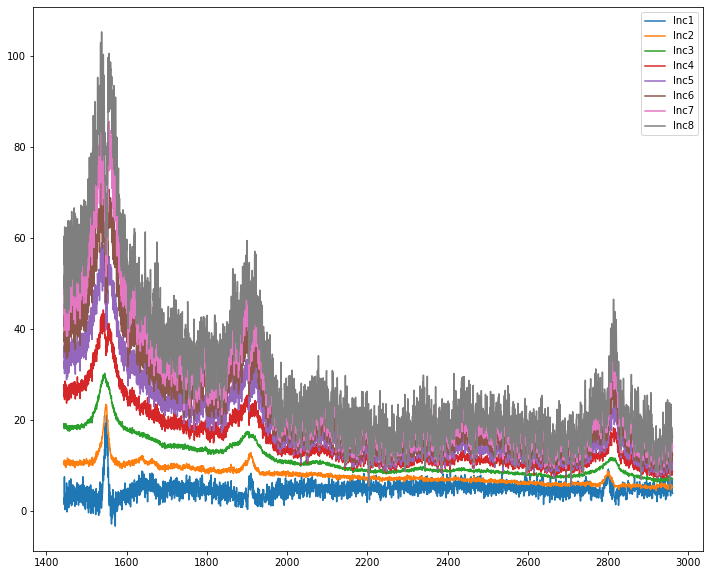

In [449]:
plot_latent(predict6, reverse=False)
plot_latent(predict6, omit=4, reverse=False)

In [90]:
def plotTSNE(colorcode, mask, lab=""):
    fig = plt.figure(figsize=(9,9))
    plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=colorcode, vmin=np.percentile(colorcode, 15), 
                vmax=np.percentile(colorcode, 85), label=lab)
    plt.colorbar()
    plt.legend(loc="best")
    plt.show()

In [91]:
dat.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET_1    MI_Z2_1  LOGLBOL_1  ...  LOGEDD_RATIO_2  \
0  51608                 0 -27.635967  47.094489  ...       -0.494012   
1  51633                 0 -26.986037  46.849020  ...       -0.837157   
2  51909                 0 -27.539811  47.031922  ...       -0.780922   
3  51909                 0 -26.907112  46.713170  ...       -0.337591   
4  51883                 0 -27.177639  46.782514  ...       -0.564674   

   SPECIAL_INTEREST_FLAG    Z_HW_2  Z_HW_ERR  \
0                      0  1.779394  0.001750   
1                      0  1.882529  0.002026   
2                      0  1.668503  0.001680   
3                      0  1.750491  0.001797   
4                      0  1.823599  0.001849   

                                               UGRIZ  \
0  (18.360000610351562, 18.19099998474121, 18.083...   
1  (19.43400001525879, 18.878000259399414, 18.794...   
2  (18.4060001373291, 18.243999481201172, 18.0189...   
3  (18.82699966430664, 18.69700050354004, 18.6709...   
4  (18.757999420166016, 18.59600067138672, 18.552...   

                                           UGRIZ_ERR  \
0  (0.017999999225139618, 0.014000000432133675, 0...   
1  (0.08100000023841858, 0.020999999716877937, 0....   
2  (0.020999999716877937, 0.014000000432133675, 0...   
3  (0.024000000208616257, 0.017999999225139618, 0...   
4  (0.019999999552965164, 0.017999999225139618, 0...   

                                         UGRIZ_DERED  DELTA_G_I    E_BV_2  \
0  (18.001000612974167, 17.926775991916656, 17.89...  -0.037049  0.069739   
1  (19.252000018954277, 18.74404826760292, 18.696...  -0.060394  0.035407   
2  (18.178000137209892, 18.07619148492813, 17.897...   0.209583  0.044319   
3  (18.662999659776688, 18.576296500861645, 18.58...  -0.121854  0.031931   
4  (18.50699943304062, 18.411264687776566, 18.418...  -0.134676  0.048818   

   Separation  
0    0.009446  
1    0.013102  
2    0.012673  
3    0.005305  
4    0.010948  

[5 rows x 65 columns]

In [92]:
len(found)

8368

In [94]:
dat[["LOGLBOL_1"]].values.flatten()

array([47.09448912, 46.8490198 , 47.03192224, ..., 47.08738135,
       46.77145762, 46.43468484])

In [451]:
np.percentile(dat[["LOGLBOL_1"]].values.flatten(), 15)

46.588360133665574

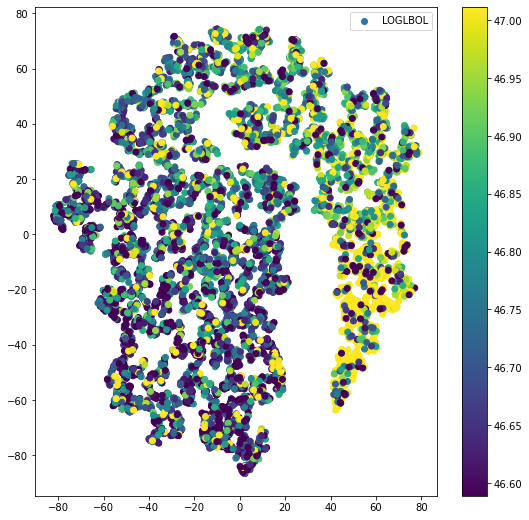

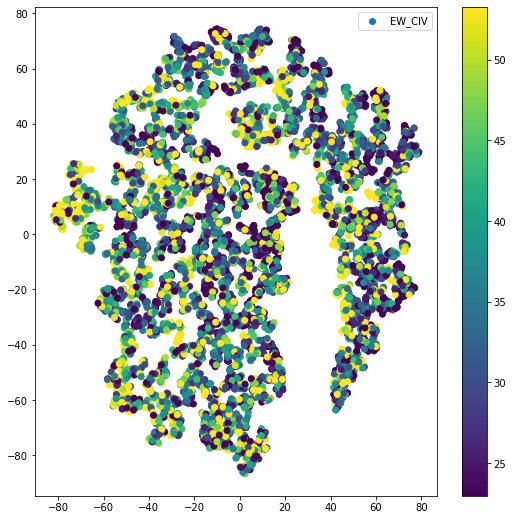

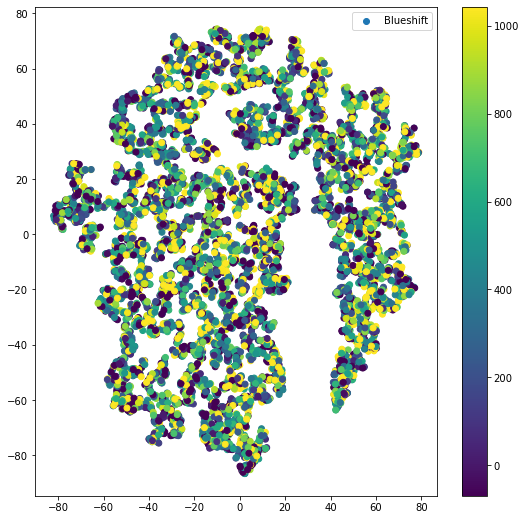

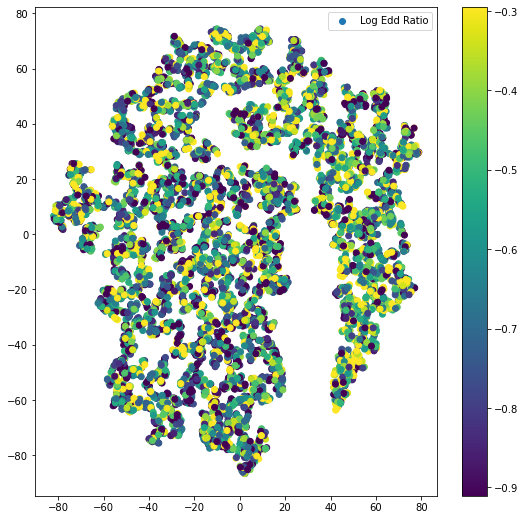

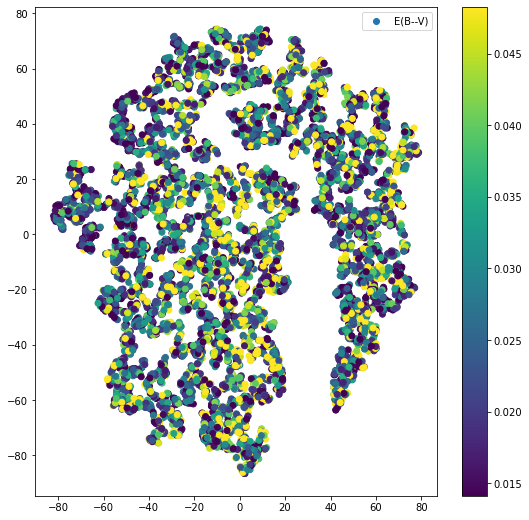

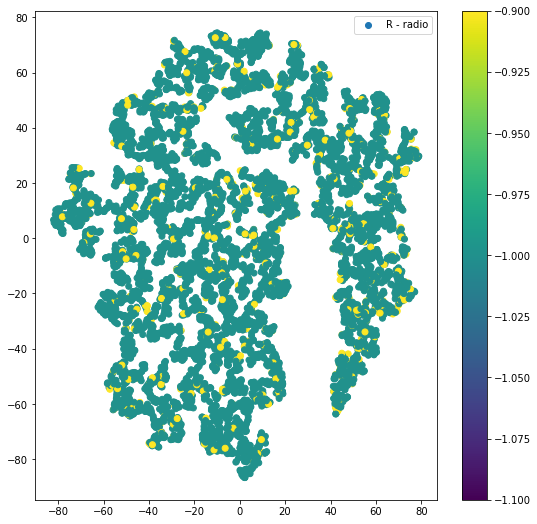

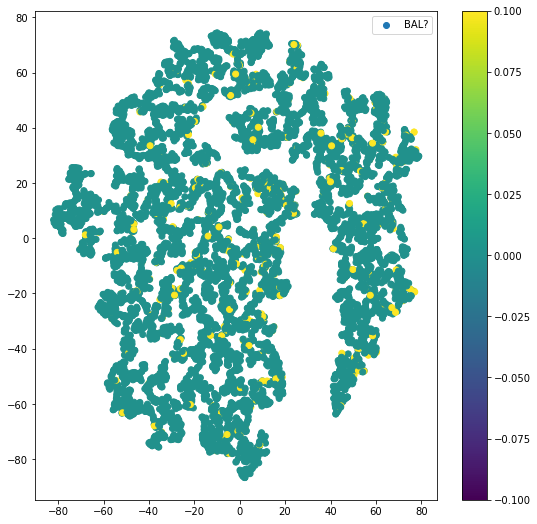

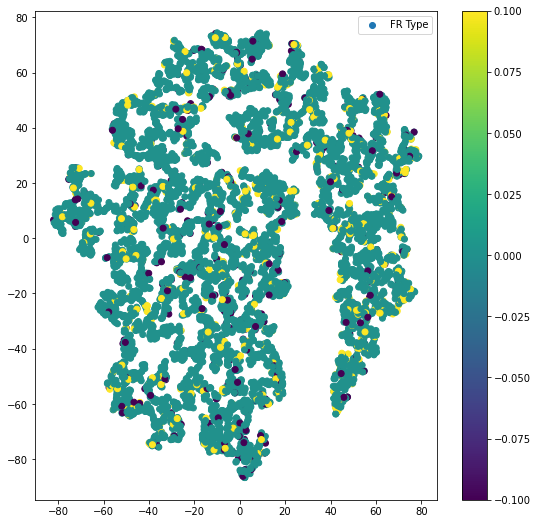

In [452]:
plotTSNE(dat[["LOGLBOL_1"]].values.flatten()[found.astype(int)], found.astype(int), "LOGLBOL")
plotTSNE(dat[["EW_CIV_1"]].values.flatten()[found.astype(int)], found.astype(int), "EW_CIV")
plotTSNE(dat[["VOFF_CIV_PEAK_1"]].values.flatten()[found.astype(int)], found.astype(int), "Blueshift")
plotTSNE(dat[["LOGEDD_RATIO_1"]].values.flatten()[found.astype(int)], found.astype(int), "Log Edd Ratio")
plotTSNE(dat[["E_BV_1"]].values.flatten()[found.astype(int)], found.astype(int), "E(B--V)")
plotTSNE(dat[["R_6CM_2500A_1"]].values.flatten()[found.astype(int)], found.astype(int), "R - radio")
plotTSNE(dat[["BAL_FLAG_1"]].values.flatten()[found.astype(int)], found.astype(int), "BAL?")
plotTSNE(dat[["FIRST_FR_TYPE_1"]].values.flatten()[found.astype(int)], found.astype(int), "FR Type")

Maybe objects with high Lbol like to hang in the upper right??

Do PCA and throw out some lower-significance components.  Then t-SNE again.

In [453]:
from sklearn.decomposition import PCA
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

In [454]:
pipe = Pipeline([('scaler', StandardScaler()), #normalizing data
                ('reducer', PCA())])           #dimensionality reduction

pc = pipe.fit_transform(X_compressed)          #data goes here for processing

#Extracting useful metrics
var = pipe.steps[1][1].explained_variance_ratio_
var_sum = pipe.steps[1][1].explained_variance_ratio_.cumsum()

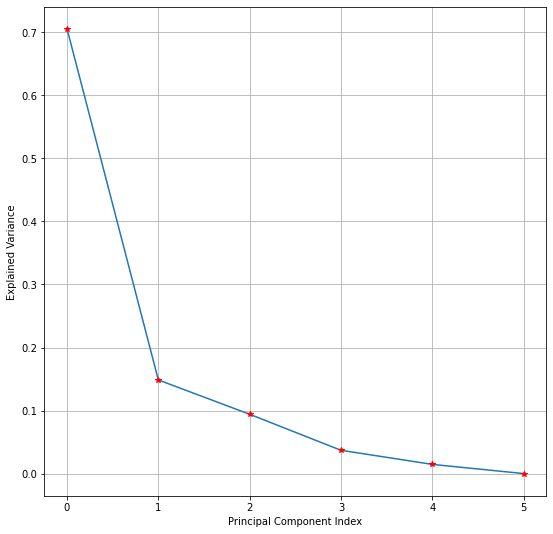

In [455]:
fig = plt.figure(figsize=(9,9))

plt.plot(var)
plt.plot(var,'r*')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

Did PCA order the features for me??  Maybe don't want this.

In [456]:
pc.shape

(8368, 6)

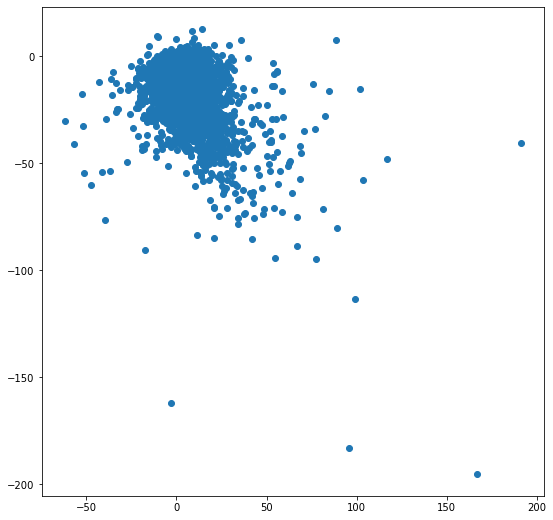

In [457]:
fig = plt.figure(figsize=(9,9))
plt.scatter(X_compressed[:,0], X_compressed[:,1])
plt.show()

In [458]:
pd.DataFrame(X_compressed)

0          1          2          3          4           5
0     10.995173 -24.321989 -86.158257 -23.353455 -23.098145  145.165146
1      3.507659 -15.365338 -41.509838  -8.665313 -19.529541   88.458229
2      2.539161  -4.128629 -97.612999 -20.272467  -3.241336  139.013672
3      4.729470 -16.875517 -40.656452 -10.279890 -16.192554   79.730820
4      6.467855 -15.585965 -41.874725 -15.720461 -12.612712   69.491760
...         ...        ...        ...        ...        ...         ...
8363   0.455447  -5.874587 -18.979013  -5.312027  -4.418582   29.148905
8364  -8.480397  -4.286370 -22.546194   4.980554  -3.070165   48.152527
8365  -0.009316  -8.962918 -43.675255 -13.662197 -12.120856   74.551193
8366   3.442668  -8.840516 -27.259092 -12.530620 -10.177098   45.741066
8367   1.225306  -4.878331 -23.432997  -5.242816  -6.277781   40.915077

[8368 rows x 6 columns]

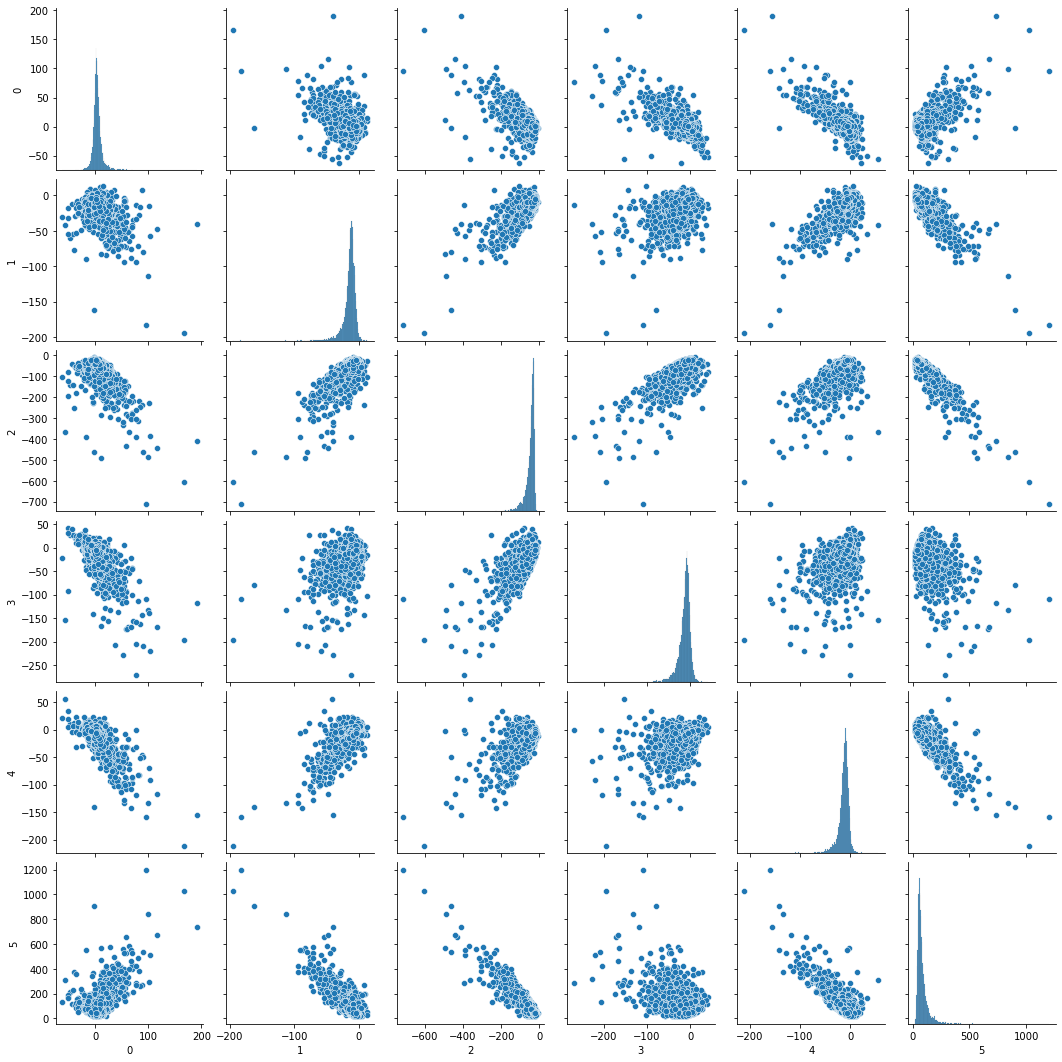

In [459]:
import seaborn

df = pd.DataFrame(X_compressed)

seaborn.pairplot(df)

---

Compute CIV EW and blueshift

In [464]:
X

array([[33.21803  , 33.921223 , 30.724604 , ..., 14.846318 , 13.317695 ,
        14.151351 ],
       [19.874874 , 20.790903 , 20.043615 , ...,  6.335633 ,  6.9407854,
         5.820573 ],
       [22.482862 , 23.138777 , 27.171658 , ..., 15.81914  , 15.413137 ,
        15.096482 ],
       ...,
       [14.459191 , 14.279158 , 14.267829 , ...,  7.5751047,  6.3564477,
         6.341022 ],
       [ 3.3154058,  6.9089637, 10.638741 , ...,  4.696215 ,  3.627235 ,
         6.040976 ],
       [ 7.4278784,  9.064822 ,  7.5617237, ...,  3.4098907,  4.9049726,
         3.3274734]], dtype=float32)

In [492]:
%%capture

def get_CIV(wave, flux, reconstruction, name):
    #Going to save plots, but not show with magic above
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(wave, flux)
    ax.plot(wave, reconstruction, label="Autoencoder Reconstruction")
    ax.plot([1549.48,1549.48], [0.2*max(reconstruction), max(reconstruction)+2], "--k", label="Laboratory Wavelength - CIV")

    
    #Fit continuum
    cont1 = ((wave>=1445)&(wave<=1465))
    cont2 = ((wave>=1700)&(wave<=1705))
    ax.axvspan(1445, 1465, alpha=0.5, color='grey')
    ax.axvspan(1700, 1705, alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave[cont1], wave[cont2])), np.concatenate((reconstruction[cont1], reconstruction[cont2])), 1)
    continuum = wave*m + b
    ax.plot(wave, continuum, "-r", label="Power-law Continuum")\

    
    #Plot EW region under reconstruction
    EW = ((wave>=1500)&(wave<=1600))
    ax.fill_between(wave[EW], continuum[EW], reconstruction[EW], color="blue", alpha=0.2)

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave[EW])):
        try:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i+1] - wave[EW][i] )
        except IndexError:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i] - wave[EW][i-1] )

        ew_list.append(CIV_EW)


    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave[EW][ind_half_flux])
    ax.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [0.2*max(reconstruction), max(reconstruction)+2], "--b", label="Observed Wavelength - Blue = %.2f km/s" % CIV_blue)

    ax.set_xlim(1435, 1710)
    ax.set_ylim(0.2*max(reconstruction), max(reconstruction)+2)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("/Users/Trevor1/Desktop/data/spectra/VLA_8403col_1.6z2.2/pngs_CIV/{}.png".format(name))
    #plt.show()
    
    return CIV_blue, CIV_EW

In [ ]:
%%capture

reconstructions = stacked_ae.predict(X)
print("done reconstructions")

blue_list = []
ew_list   = []

for i in range(len(X)):
    civ_blue, civ_ew = get_CIV(wave[i], X[i], reconstructions[i], names[i])
    blue_list.append(civ_blue)
    ew_list.append(ew_list)

Cell above never ended even though all the plots were done??  Fix this so I can actually save EW+blueshift!

In [496]:
CIV_data = np.array([blue_list, ew_list]).T
CIV_df   = pd.DataFrame(X_compressed, columns=["CIV_Blueshift_AE", "CIV_EW_AE"])
CIV_df.head()

(8368, 6)

---

Save a file with the latent parameters and reconstructions.

In [461]:
latent_params = pd.DataFrame(X_compressed, columns=["Latent{}".format(i) for i in range(1,7)])
latent_params.head()

Latent1    Latent2    Latent3    Latent4    Latent5     Latent6
0  10.995173 -24.321989 -86.158257 -23.353455 -23.098145  145.165146
1   3.507659 -15.365338 -41.509838  -8.665313 -19.529541   88.458229
2   2.539161  -4.128629 -97.612999 -20.272467  -3.241336  139.013672
3   4.729470 -16.875517 -40.656452 -10.279890 -16.192554   79.730820
4   6.467855 -15.585965 -41.874725 -15.720461 -12.612712   69.491760

In [462]:
sample_cut = dat.iloc[found]
sample_cut.shape

(8368, 65)

In [275]:
TSNE2 = pd.DataFrame(projTSNE2, columns=["TSNE_X", "TSNE_Y"])
TSNE2.head()

TSNE_X     TSNE_Y
0 -59.974598   5.428302
1  10.624625 -70.629379
2 -70.111412  -2.025018
3  24.048346 -53.701729
4  25.743031 -37.835445

In [276]:
df = pd.merge(sample_cut, latent_params, right_index=True, left_index=True)
df2= pd.merge(df, TSNE2, right_index=True, left_index=True)
df3= pd.merge(df2, CIV_df)
df2.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET_1    MI_Z2_1  LOGLBOL_1  ...  \
0  51608                 0 -27.635967  47.094489  ...   
1  51633                 0 -26.986037  46.849020  ...   
2  51909                 0 -27.539811  47.031922  ...   
3  51909                 0 -26.907112  46.713170  ...   
4  51883                 0 -27.177639  46.782514  ...   

                                         UGRIZ_DERED  DELTA_G_I    E_BV_2  \
0  (18.001000612974167, 17.926775991916656, 17.89...  -0.037049  0.069739   
1  (19.252000018954277, 18.74404826760292, 18.696...  -0.060394  0.035407   
2  (18.178000137209892, 18.07619148492813, 17.897...   0.209583  0.044319   
3  (18.662999659776688, 18.576296500861645, 18.58...  -0.121854  0.031931   
4  (18.50699943304062, 18.411264687776566, 18.418...  -0.134676  0.048818   

   Separation    Latent1     Latent2     Latent3    Latent4     TSNE_X  \
0    0.009446  47.630016  197.039566 -184.120697 -89.203102 -59.974598   
1    0.013102  36.250057  113.706329 -103.534317 -45.116665  10.624625   
2    0.012673  14.480593  204.195328 -176.934036 -88.136490 -70.111412   
3    0.005305  32.013721  105.890999  -96.678314 -44.374863  24.048346   
4    0.010948  27.914503   92.677177  -92.593033 -46.193886  25.743031   

      TSNE_Y  
0   5.428302  
1 -70.629379  
2  -2.025018  
3 -53.701729  
4 -37.835445  

[5 rows x 71 columns]

In [282]:
! ls ../../data/files/VLA2018b/

grdr7.8403col.radec.platemjdfiber.csv


In [283]:
df2.to_csv("grdr7.8403col.radec.platemjdfiber_w4LatentParams.csv")